# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

__Признаки:__
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

__Целевой признак:__  
- Exited — факт ухода клиента

__Инструкция по выполнению проекта__

- Загрузите и подготовьте данные. Поясните порядок действий.
- Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
- Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
- Проведите финальное тестирование.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score

In [2]:
# отключим некритические предупреждения в коде

warnings.filterwarnings("ignore")

In [3]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('/Users/alex/Downloads/Churn.csv')

data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
# приведем столбцы к нижнему, привычному регистру

data.columns = (data.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex = True)
                .str.lower()
             )

In [5]:
# проверим

data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [8]:
data[data['tenure'].isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Т.к у нас нет возможности правильно и корректно заполнить пропуски(менее 10 %), принимаем решение удалить их.

In [9]:
tenure_nan = data[data['tenure'].isna()].index
data.drop(tenure_nan, inplace = True, axis = 0)
data.reset_index(inplace = True, drop = True)
# Размер после удаления
print(data.shape)

(9091, 14)


Так же, за ненадобностью удалим столбцы __row_number, customer_id, и surname__, дабы в дальнейшем , при использовании Ohe не появилось куча ненужных столбцов из-за категориальных данных столбце с фамилиями

In [10]:
data.drop(['row_number', 'customer_id', 'surname'], axis = 1, inplace = True)
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
data.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


## Исследование задачи

__Исследуем баланс классов__

0    7237
1    1854
Name: exited, dtype: int64

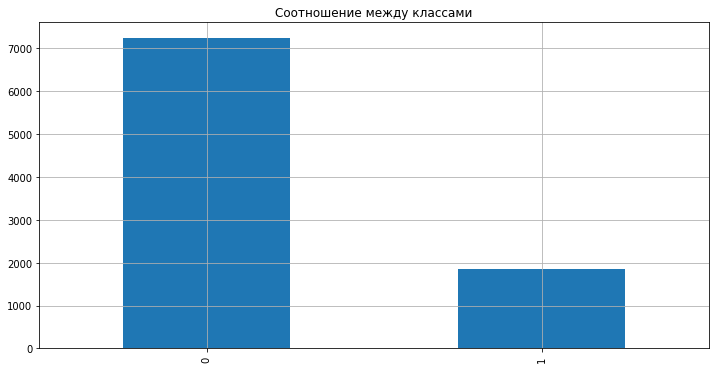

In [12]:
data['exited'].value_counts().plot(kind = 'bar',
                                   grid = True, figsize = (12, 6),
                                   title = 'Соотношение между классами');
data['exited'].value_counts()

Мы видим, что кол-во классов разнится почти в 4 раза, что говорит нам о дисбалансе классов.

In [13]:
# присвоим переменной значение для дальнейшего использования в random_state

my_random_state = 12345

__Разделим данные на тренировочную и тестовую выборки__

Далее используем технику прямого кодирования она же - Ohe к нашей __тренировочной__ выборке, затем выделим наши features и target, после разделим наши __Обработанные данные__ на __train и valid__ выборки, затем __стандартизируем__ наши числовые данные(так как имеются оч малые и большие значения) и будем обучать модели.

К __Тестовой выборке__ мы вернемся в самом конце на этапе тестирования, дабы не подглядывать в нее и не допустить утечки данных(data leakege), к ней мы применим уже обученные алгоритмы

In [14]:
# раздели наши данные на трейн и тест

data_train, data_test = train_test_split(data, test_size = 0.2, random_state = my_random_state, shuffle = True)

In [15]:
print(data_train.shape)
print(data_test.shape)

(7272, 11)
(1819, 11)


In [16]:
# Избавимся от категориальных переменных , применим технику Ohe

data_ohe = pd.get_dummies(data_train, drop_first = True)

In [17]:
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
6990,850,31,8.0,0.00,2,1,0,178667.70,0,0,0,1
3892,573,56,3.0,154669.77,1,0,1,115462.27,1,0,1,1
6778,850,47,4.0,99219.47,2,1,1,122141.13,0,1,0,0
4701,826,41,5.0,146466.46,2,0,0,180934.67,0,0,1,1
623,742,33,0.0,181656.51,1,1,1,107667.91,0,1,0,1


In [18]:
# выделим features and target

features = data_ohe.drop(['exited'], axis = 1)
target = data_ohe['exited']

In [19]:
# разделим данные на train и valid

features_train, features_valid, target_train, target_valid = train_test_split(
                                features,target, test_size = 0.25, random_state = my_random_state, shuffle = True)

print(features_train.shape)
print(features_valid.shape)

(5454, 11)
(1818, 11)


In [20]:
# Стандартизируем наши выборки с помощью(StandardScaler), т.к есть значения и маленькие и очень большие.

numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [21]:
features_valid.head(2)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
4350,-1.003024,1.232342,-1.373506,-1.230577,-0.914942,-1.545860,-1.016640,-0.626048,0,0,1
357,-0.941546,-0.575198,-0.683177,-0.354876,-0.914942,0.646889,0.983632,-1.722595,0,0,1


In [22]:
features_train.head(2)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
3353,-0.203819,0.471273,0.352316,0.786022,0.782369,-1.545860,-1.016640,-0.357205,0,1,0
6176,-0.357513,-0.384930,-1.373506,-1.230577,0.782369,0.646889,0.983632,-1.671048,0,0,0


# построим модели без учета баланса

__Модель - СЛУЧАЙНЫЙ ЛЕС__

In [23]:
# Напишем цикл для модели Случайный лес, выведем лучший результат.

best_depth_rfc = 0
best_f1_score_rfc = 0
best_est_rfc = 0
best_model_rfc = None
best_auc_roc_rfc = 0

for est in range(1, 40):
    for depth in range(1, 20):
        model_rfc = RandomForestClassifier(random_state = my_random_state, max_depth = depth, n_estimators = est)
        model_rfc.fit(features_train, target_train)        
        prediction_rfc = model_rfc.predict(features_valid)
        
        probabilities_valid_rfc = model_rfc.predict_proba(features_valid)[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_valid_rfc) 
        
        f1_score_rfc = f1_score(target_valid, prediction_rfc)
        
        if f1_score_rfc > best_f1_score_rfc:
            best_f1_score_rfc = f1_score_rfc
            best_depth_rfc = depth
            best_est_rfc = est
            best_model_rfc = model_rfc
            best_auc_roc_rfc = auc_roc_rfc

print(f'F1 Score лучшей модели равна: {best_f1_score_rfc.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_rfc.round(4)}')
print(f'Количество деревьев: {best_est_rfc}') 
print(f'Глубина дерева: {best_depth_rfc}')
print(best_model_rfc)

F1 Score лучшей модели равна: 0.5681
Roc_auc лучшей модели равна: 0.821
Количество деревьев: 13
Глубина дерева: 17
RandomForestClassifier(max_depth=17, n_estimators=13, random_state=12345)


__Модель - ДЕРЕВО РЕШЕНИЙ__

In [24]:
# Напишем цикл для модели Дерево решений, выведем лучший результат.

best_depth_dtc = 0
best_f1_score_dtc = 0
best_model_dtc = None
best_auc_roc_dtc = 0

for depth in range(1, 15):
    model_dtc = DecisionTreeClassifier(random_state = my_random_state, max_depth = depth)
    model_dtc.fit(features_train,target_train)
    predictions_dtc = model_dtc.predict(features_valid)
    
    probabilities_valid_dtc = model_dtc.predict_proba(features_valid)[:, 1]
    auc_roc_dtc = roc_auc_score(target_valid, probabilities_valid_dtc)
    
    f1_score_dtc = f1_score(target_valid, predictions_dtc)
    if f1_score_dtc > best_f1_score_dtc:
        best_f1_score_dtc = f1_score_dtc
        best_depth_dtc = depth
        best_model_dtc = model_dtc
        best_auc_roc_dtc = auc_roc_dtc
        
print(f'F1 Score лучшей модели равна: {best_f1_score_dtc.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_dtc.round(4)}')
print(f'Глубина дерева: {best_depth_dtc}')
print(best_model_dtc)

F1 Score лучшей модели равна: 0.5574
Roc_auc лучшей модели равна: 0.8063
Глубина дерева: 9
DecisionTreeClassifier(max_depth=9, random_state=12345)


__Модель - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ__

In [25]:
model_lr = LogisticRegression(random_state = my_random_state, solver='liblinear')
model_lr.fit(features_train, target_train)
prediction_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_valid_lr)

f1_score_lr = f1_score(target_valid,prediction_lr)

print(f'F1 Score равна: {f1_score_lr.round(4)}')
print(f'Roc_auc равна: {auc_roc_lr.round(4)}')

F1 Score равна: 0.3004
Roc_auc равна: 0.7726


__Промежуточнй вывод.__

Обучив 3 модели, мы видим следующую картину - самые высокие метрики F1 Score и показатель площади Roc_auc - получилась у модели __Случайный лес__, при кол-ве деревьев равное 13 и глубине 17 - составляет 0.568 и 0.821 соответсвенно. Самый низкий показатель - у __Логистической регрессии__ - составляет f1 - 0.3, Roc_auc - 0.77

## Борьба с дисбалансом

На данном этапе воспользуемся "функциями" - __upsampling__'а и __downsampling__'а , обучим модели и глянем на результаты. Далее - будем менять гиперпараметр __"class_weight"__ и сравним результаты.

__Upsampling__

In [26]:
# функция получает на вход признаки, таргет и кол-во повторений

def upsample(features, target, repeat):
    # Разделяем выборку по значениям целевой функции
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Увеличиваем и соединяем обратно
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Перемешиваем
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state = my_random_state)
    
    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


In [27]:
print(features_upsampled.shape)
print(target_upsampled.shape)

(8811, 11)
(8811,)


In [28]:
# соотношение классов после Upsampling

target_upsampled.value_counts()

1    4476
0    4335
Name: exited, dtype: int64

Обучим наши модели

__Модель - СЛУЧАЙНЫЙ ЛЕС__

In [29]:
best_depth_rfc_up = 0
best_f1_score_rfc_up = 0
best_est_rfc_up = 0
best_model_rfc_up = None
best_auc_roc_rfc_up = 0

for est in range(1, 40):
    for depth in range(1, 20):
        model_rfc_up = RandomForestClassifier(random_state = my_random_state, max_depth = depth, n_estimators = est)
        model_rfc_up.fit(features_upsampled, target_upsampled)
        prediction_rfc_up = model_rfc_up.predict(features_valid)
        
        probabilities_valid_rfc_up = model_rfc_up.predict_proba(features_valid)[:, 1]
        auc_roc_rfc_up = roc_auc_score(target_valid, probabilities_valid_rfc_up)
        
        f1_score_rfc_up = f1_score(target_valid, prediction_rfc_up)
        if f1_score_rfc_up > best_f1_score_rfc_up:
            best_f1_score_rfc_up = f1_score_rfc_up
            best_depth_rfc_up = depth
            best_est_rfc_up = est
            best_model_rfc_up = model_rfc_up
            best_auc_roc_rfc_up = auc_roc_rfc_up

print(f'F1 до Upsampling лучшей модели равна: {best_f1_score_rfc.round(4)}, после: {best_f1_score_rfc_up.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_rfc_up.round(4)}')
print(f'Количество деревьев: {best_est_rfc_up}') 
print(f'Глубина дерева: {best_depth_rfc_up}')
print(best_model_rfc_up)

F1 до Upsampling лучшей модели равна: 0.5681, после: 0.6112
Roc_auc лучшей модели равна: 0.8396
Количество деревьев: 22
Глубина дерева: 12
RandomForestClassifier(max_depth=12, n_estimators=22, random_state=12345)


__Модель - ДЕРЕВО РЕШЕНИЙ__

In [30]:
best_depth_dtc_up = 0
best_f1_score_dtc_up = 0
best_model_dtc_up = None
best_auc_roc_dtc_up = 0

for depth in range(1, 15):
    model_dtc_up = DecisionTreeClassifier(random_state = my_random_state, max_depth = depth)
    model_dtc_up.fit(features_upsampled, target_upsampled)
    predictions_dtc_up = model_dtc_up.predict(features_valid)
    
    probabilities_valid_dtc_up = model_dtc_up.predict_proba(features_valid)[:, 1]
    auc_roc_dtc_up = roc_auc_score(target_valid, probabilities_valid_dtc_up)    
    
    f1_score_dtc_up = f1_score(target_valid, predictions_dtc_up)
    if f1_score_dtc_up > best_f1_score_dtc_up:
        best_f1_score_dtc_up = f1_score_dtc_up
        best_depth_dtc_up = depth
        best_model_dtc_up = model_dtc_up
        best_auc_roc_dtc_up = auc_roc_dtc_up
        
print(f'F1 до Upsampling лучшей модели равна: {best_f1_score_dtc.round(4)}, после: {best_f1_score_dtc_up.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_dtc_up.round(4)}')
print(f'Глубина дерева: {best_depth_dtc_up}')
print(best_model_dtc_up)

F1 до Upsampling лучшей модели равна: 0.5574, после: 0.5556
Roc_auc лучшей модели равна: 0.815
Глубина дерева: 7
DecisionTreeClassifier(max_depth=7, random_state=12345)


__Модель - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ__

In [31]:
model_lr_up = LogisticRegression(random_state = my_random_state, solver='liblinear')
model_lr_up.fit(features_upsampled, target_upsampled)
prediction_up = model_lr_up.predict(features_valid)

probabilities_valid_lr_up = model_lr_up.predict_proba(features_valid)[:, 1]
auc_roc_lr_up = roc_auc_score(target_valid, probabilities_valid_lr_up)

f1_score_lr_up = f1_score(target_valid, prediction_up)

print(f'F1 Score до - равна: {f1_score_lr.round(4)}, после: {f1_score_lr_up.round(4)}')
print(f'Roc_auc до - равна: {auc_roc_lr_up.round(4)}')

F1 Score до - равна: 0.3004, после: 0.4957
Roc_auc до - равна: 0.7748


__Промежуточный вывод__

Применив технику Upsampling, мы наблюдаем слудующее, метрика F1 score - увеличилась почти на 0.2 - 0.495, Roc_auc так же увеличилась до 0.77 у __логистической регрессии__, у модели __случайный лес__ F1 score - почти не изменилась - 0.5556 Roc_auc - немного увеличилась, что касается __дерева решения__  оно показало себя лучше остальных, метрика F1 увеличилась с 0.5681 до 0.611, Roc_auc тоже немного увеличилась.

__Downsampling__

In [32]:
def downsample(features, target, fraction):
    # Разделяем выборку по значениям целевой функции
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Уменьшаем и соединяем обратно
    features_downsampled = pd.concat(
        [features_zeros.sample(frac = fraction, random_state = my_random_state)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac = fraction, random_state = my_random_state)] + [target_ones])
    
    # Перемешиваем
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state = my_random_state)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.27)

In [33]:
print(features_downsampled.shape)
print(target_downsampled.shape)

(2289, 11)
(2289,)


In [34]:
# соотношение классов после Downsampling

target_downsampled.value_counts()

0    1170
1    1119
Name: exited, dtype: int64

Обучим наши модели

__Модель - СЛУЧАЙНЫЙ ЛЕС__

In [35]:
best_depth_rfc_down = 0
best_f1_score_rfc_down = 0
best_est_rfc_down = 0
best_model_rfc_down = None
best_auc_roc_rfc_down = 0

for est in range(1, 40):
    for depth in range(1, 20):
        model_rfc_down = RandomForestClassifier(random_state = my_random_state, max_depth = depth, n_estimators = est)
        model_rfc_down.fit(features_downsampled, target_downsampled)
        prediction_rfc_down = model_rfc_down.predict(features_valid)
        
        probabilities_valid_rfc_down = model_rfc_down.predict_proba(features_valid)[:, 1]
        auc_roc_rfc_down = roc_auc_score(target_valid, probabilities_valid_rfc_down)
        
        f1_score_rfc_down = f1_score(target_valid, prediction_rfc_down)
        if f1_score_rfc_down > best_f1_score_rfc_down:
            best_f1_score_rfc_down = f1_score_rfc_down
            best_depth_rfc_down = depth
            best_est_rfc_down = est
            best_model_rfc_down = model_rfc_down
            best_auc_roc_rfc_down = auc_roc_rfc_down

print(f'F1 до Downsampling лучшей модели равна: {best_f1_score_rfc.round(4)}, после: {best_f1_score_rfc_down.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_rfc_down.round(4)}')
print(f'Количество деревьев: {best_est_rfc_down}') 
print(f'Глубина дерева: {best_depth_rfc_down}')
print(best_model_rfc_down)

F1 до Downsampling лучшей модели равна: 0.5681, после: 0.597
Roc_auc лучшей модели равна: 0.8502
Количество деревьев: 31
Глубина дерева: 8
RandomForestClassifier(max_depth=8, n_estimators=31, random_state=12345)


__Модель - ДЕРЕВО РЕШЕНИЙ__

In [36]:
best_depth_dtc_down = 0
best_f1_score_dtc_down = 0
best_model_dtc_down = None
best_auc_roc_dtc_down = 0

for depth in range(1, 15):
    model_dtc_down = DecisionTreeClassifier(random_state = my_random_state, max_depth = depth)
    model_dtc_down.fit(features_downsampled, target_downsampled)
    predictions_dtc_down = model_dtc_down.predict(features_valid)
    
    probabilities_valid_dtc_down = model_dtc_down.predict_proba(features_valid)[:, 1]
    auc_roc_dtc_down = roc_auc_score(target_valid, probabilities_valid_dtc_down)    
    
    f1_score_dtc_down = f1_score(target_valid, predictions_dtc_down)
    if f1_score_dtc_down > best_f1_score_dtc_down:
        best_f1_score_dtc_down = f1_score_dtc_down
        best_depth_dtc_down = depth
        best_model_dtc_down = model_dtc_down
        best_auc_roc_dtc_down = auc_roc_dtc_down
        
print(f'F1 до Downsampling лучшей модели равна: {best_f1_score_dtc.round(4)}, после: {best_f1_score_dtc_down.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_dtc_down.round(4)}')
print(f'Глубина дерева: {best_depth_dtc_down}')
print(best_model_dtc_down)

F1 до Downsampling лучшей модели равна: 0.5574, после: 0.5736
Roc_auc лучшей модели равна: 0.8111
Глубина дерева: 5
DecisionTreeClassifier(max_depth=5, random_state=12345)


__Модель - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ__

In [37]:
model_lr_down = LogisticRegression(random_state = my_random_state, solver='liblinear')
model_lr_down.fit(features_downsampled, target_downsampled)
prediction_down = model_lr_down.predict(features_valid)

probabilities_valid_lr_down = model_lr_down.predict_proba(features_valid)[:, 1]
auc_roc_lr_down = roc_auc_score(target_valid, probabilities_valid_lr_down) 

f1_score_lr_down = f1_score(target_valid, prediction_down)

print(f'F1 Score до - равна: {f1_score_lr.round(4)}, после: {f1_score_lr_down.round(4)}')
print(f'Roc_auc - равна: {auc_roc_lr_down.round(4)}')

F1 Score до - равна: 0.3004, после: 0.4995
Roc_auc - равна: 0.7755


__Промежуточный вывод__

Как мы можем заметить при уменьшении выборки, метрика F1 и Roc_auc практически не изменили, даже немного уменьшились

# __Укажем гиперпараметр class_weight = 'balanced'__

__Модель - СЛУЧАЙНЫЙ ЛЕС__

In [38]:
best_depth_rfc_blnc = 0
best_f1_score_rfc_blnc = 0
best_est_rfc_blnc = 0
best_model_rfc_blnc = None
best_auc_roc_rfc_blnc = 0

for est in range(1, 40):
    for depth in range(1, 20):
        model_rfc_blnc=RandomForestClassifier(random_state=my_random_state, max_depth=depth, n_estimators=est,class_weight='balanced')
        model_rfc_blnc.fit(features_train, target_train)
        prediction_rfc_blnc = model_rfc_blnc.predict(features_valid)
        
        probabilities_valid_rfc_blnc = model_rfc_blnc.predict_proba(features_valid)[:, 1]
        auc_roc_rfc_blnc = roc_auc_score(target_valid, probabilities_valid_rfc_blnc) 
        
        f1_score_rfc_blnc = f1_score(target_valid, prediction_rfc_blnc)
        
        if f1_score_rfc_blnc > best_f1_score_rfc_blnc:
            best_f1_score_rfc_blnc = f1_score_rfc_blnc
            best_depth_rfc_blnc = depth
            best_est_rfc_blnc = est
            best_model_rfc_blnc = model_rfc_blnc
            best_auc_roc_rfc_blnc = auc_roc_rfc_blnc

print(f'F1 Score до Balanced, лучшей модели равна: {best_f1_score_rfc.round(4)}, после: {best_f1_score_rfc_blnc.round(4)}')
print(f'Roc_auc, лучшей модели равна: {best_auc_roc_rfc_blnc.round(4)}')
print(f'Количество деревьев: {best_est_rfc_blnc}') 
print(f'Глубина дерева: {best_depth_rfc_blnc}')
print(best_model_rfc_blnc)

F1 Score до Balanced, лучшей модели равна: 0.5681, после: 0.6058
Roc_auc, лучшей модели равна: 0.8486
Количество деревьев: 33
Глубина дерева: 9
RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=33,
                       random_state=12345)


__Модель - ДЕРЕВО РЕШЕНИЙ__

In [39]:
best_depth_dtc_blnc = 0
best_f1_score_dtc_blnc = 0
best_model_dtc_blnc = None
best_auc_roc_dtc_blnc = 0

for depth in range(1, 15):
    model_dtc_blnc = DecisionTreeClassifier(random_state = my_random_state, max_depth = depth, class_weight='balanced')
    model_dtc_blnc.fit(features_train,target_train)
    predictions_dtc_blnc = model_dtc_blnc.predict(features_valid)
    
    probabilities_valid_dtc_blnc = model_dtc_blnc.predict_proba(features_valid)[:, 1]
    auc_roc_dtc_blnc = roc_auc_score(target_valid, probabilities_valid_dtc_blnc)
    
    f1_score_dtc_blnc = f1_score(target_valid, predictions_dtc_blnc)
    if f1_score_dtc_blnc > best_f1_score_dtc_blnc:
        best_f1_score_dtc_blnc = f1_score_dtc_blnc
        best_depth_dtc_blnc = depth
        best_model_dtc_blnc = model_dtc_blnc
        best_auc_roc_dtc_blnc = auc_roc_dtc_blnc
        
print(f'F1 Score до Balanced лучшей модели равна: {best_f1_score_dtc.round(4)}, после: {best_f1_score_dtc_blnc.round(4)}')
print(f'Roc_auc лучшей модели равна: {best_auc_roc_dtc_blnc.round(4)}')
print(f'Глубина дерева: {best_depth_dtc_blnc}')
print(best_model_dtc_blnc)

F1 Score до Balanced лучшей модели равна: 0.5574, после: 0.5556
Roc_auc лучшей модели равна: 0.815
Глубина дерева: 7
DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=12345)


__Модель - ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ__

In [40]:
model_lr_blnc = LogisticRegression(random_state = my_random_state, solver='liblinear',class_weight = 'balanced')
model_lr_blnc.fit(features_train, target_train)
prediction_blnc = model_lr_blnc.predict(features_valid)

probabilities_valid_lr_blnc = model_lr_blnc.predict_proba(features_valid)[:, 1]
auc_roc_lr_blnc = roc_auc_score(target_valid, probabilities_valid_lr_blnc)

f1_score_lr_blnc = f1_score(target_valid,prediction_blnc)

print(f'F1 Score до Balanced равна: {f1_score_lr.round(4)}, после: {f1_score_lr_blnc.round(4)}')
print(f'Roc_auc равна: {auc_roc_lr_blnc.round(4)}')

F1 Score до Balanced равна: 0.3004, после: 0.4946
Roc_auc равна: 0.7748


Cоздадим цикл и переберем все модельки и посчитаем метрики для каждой, на основаниии этих данных создадим табличку) 

In [41]:
models = [best_model_rfc_up, best_model_rfc_down, best_model_rfc_blnc, 
          best_model_dtc_up, best_model_dtc_down, best_model_dtc_blnc, 
          model_lr_up, model_lr_down, model_lr_blnc]


models_method = ['RFC_up', 'RFC_down','RFC_balance', 'DTC_up', 'DTC_down', 'DTC_balance', 'LR_up', 'LR_down', 'LR_balance']
columns_name = ['f1_score', 'roc_auc_score']
metrics_name = [f1_score, roc_auc_score]

result=[]

res_f1 = []
res_auc = []

for i in models:    
    res_f1.append(metrics_name[0](target_valid, i.predict(features_valid)))
    res_auc.append(metrics_name[1](target_valid, i.predict_proba(features_valid)[:,1]))
        
result.append(res_f1)
result.append(res_auc)    
    
df_result = pd.DataFrame(result,index = columns_name, columns = models_method)
df_result = df_result.transpose()
df_result

,f1_score,roc_auc_score
RFC_up,0.611187,0.839608
RFC_down,0.597049,0.850173
RFC_balance,0.605820,0.848594
DTC_up,0.555556,0.815042
DTC_down,0.573585,0.811132
DTC_balance,0.555556,0.815016
LR_up,0.495661,0.774831
LR_down,0.499486,0.775522
LR_balance,0.494581,0.774765


__Промежуточный вывод__

После выставления гиперпараметра __class_weight = 'balanced'__, мы можем наблюдать изменения в положительную сторону. В модели __случайный лес__ метрика F1 увеличилась и стала равна __0.605__(но при использовании Upsampling мы имели 0.611), что касается __дерева решений и лог.регрессию__ метрики выросли соответсвено до 0.55 и 0.49.

## Тестирование модели

Вернемся к нашей __Тестовой выборке__ трансформируем категориальные фичи и стандартизируем числовые

In [42]:
data_ohe_test = pd.get_dummies(data_test, drop_first = True)

In [43]:
# выделим features and target в нашей тестовой выборки

features_test = data_ohe_test.drop(['exited'], axis = 1)
target_test = data_ohe_test['exited']

In [44]:
# Стандартизируем нашу тестовую выборку по уже обученному scaler'у

features_test[numeric] = scaler.transform(features_test[numeric])

__Простестируем на нашей лучшей модели, и взгянем на результат.__


У нас имеются две близкие модели __RFC_up__(с F1 - 0.611 и Roc - 0.839) и __RFC_balance__(с F1 - 0.605 и Roc - 0.848), и вот встал вопрос что лучше использовать более высокую ф1 или более высокую рок.

Поискав инфу, если я правильно понял то в таких случаях (если есть диспаланс в выборках) , то лучше использовать модель где больше метрика Ф1

Будем использовать модель  best_model_rfc_up

https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc

In [45]:
random_forest_predict = best_model_rfc_up.predict(features_test)

f1_random_forest = f1_score(target_test, random_forest_predict)
roc_auc_random_forest = roc_auc_score(target_test, random_forest_predict)

print(f'Лучшая модель Случайного леса: {best_model_rfc_blnc}')
print('--------------------------------------')
print(f'F1 score: {f1_random_forest}')
print(f'Roc_auc: {roc_auc_random_forest}')

Лучшая модель Случайного леса: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=33,
                       random_state=12345)
--------------------------------------
F1 score: 0.5984251968503937
Roc_auc: 0.7520465377067564


# Вывод

При проверке нашей модели на финальном этапе -__Тестовой выборке__,  модель __Случайный лес__ - показала слудющие  метрики  - F1 score: 0.5984, Roc_auc: 0.7520. При использовании функций __upsampling'а__ прирост был самый большой, нам удалось достич отметки в 0.59